## 1. Imports

In [19]:
import os
import json
import torch
import numpy as np
from pathlib import Path
from datasets import Dataset, concatenate_datasets
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

import optuna
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
from peft import LoraConfig, get_peft_model, TaskType

## 2. Data Paths

In [20]:
TRAIN_DIR = Path(r"C:\Users\nmilo\OneDrive\Desktop\Master\Semester2\NLP\project\dataset\train")
DEV_DIR = Path(r"C:\Users\nmilo\OneDrive\Desktop\Master\Semester2\NLP\project\dataset\dev")
TEST_DIR = Path(r"C:\Users\nmilo\OneDrive\Desktop\Master\Semester2\NLP\project\dataset\test")

assert TRAIN_DIR.exists(), f"Train directory not found: {TRAIN_DIR}"
assert DEV_DIR.exists(), f"Dev directory not found: {DEV_DIR}"
assert TEST_DIR.exists(), f"Test directory not found: {TEST_DIR}"

## 3. Load DocIE Data

In [21]:
def load_docie_docs(folder: Path, recursive: bool = False):
    """Load DocIE documents from JSON files."""
    docs = []
    pattern = "**/*.json" if recursive else "*.json"
    for file in folder.glob(pattern):
        data = json.loads(file.read_text(encoding="utf-8"))
        if isinstance(data, list):
            docs.extend(data)
        else:
            docs.append(data)
    return docs

train_docs = load_docie_docs(TRAIN_DIR)
dev_docs = load_docie_docs(DEV_DIR)
test_docs = load_docie_docs(TEST_DIR, recursive=True)

print(f"Loaded documents - Train: {len(train_docs)}, Dev: {len(dev_docs)}, Test: {len(test_docs)}")

Loaded documents - Train: 51, Dev: 23, Test: 248


## 4. Prepare Relation Extraction Data

In [22]:
def create_re_examples(docs, split_name):
    """Create relation extraction examples from DocIE documents."""
    examples = []
    
    for doc in docs:
        if not doc.get("triples") or not doc.get("entities"):
            continue
            
        text = doc.get("doc") or doc.get("document")
        if not text:
            continue
            
        entity_mentions = [ent["mentions"][0] for ent in doc["entities"] if ent.get("mentions")]
        
        # Create positive examples
        for triple in doc["triples"]:
            examples.append({
                "text": f"{triple['head']} [SEP] {triple['tail']} [SEP] {text}",
                "label": triple["relation"],
                "split": split_name
            })
            
        # Create negative examples
        positive_pairs = {(triple["head"], triple["tail"]) for triple in doc["triples"]}
        negative_count = 0
        max_attempts = len(doc["triples"]) * 10
        attempts = 0
        
        while negative_count < len(doc["triples"]) and attempts < max_attempts:
            attempts += 1
            if len(entity_mentions) < 2:
                break
                
            import random
            head, tail = random.sample(entity_mentions, 2)
            if (head, tail) not in positive_pairs and (tail, head) not in positive_pairs:
                examples.append({
                    "text": f"{head} [SEP] {tail} [SEP] {text}",
                    "label": "no_relation",
                    "split": split_name
                })
                negative_count += 1
    
    return examples

# Create examples
train_examples = create_re_examples(train_docs, "train")
dev_examples = create_re_examples(dev_docs, "dev")
test_examples = create_re_examples(test_docs, "test")

print(f"RE Examples - Train: {len(train_examples)}, Dev: {len(dev_examples)}, Test: {len(test_examples)}")

RE Examples - Train: 1222, Dev: 606, Test: 0


## 5. Label Mapping

In [23]:
# Get all unique labels
all_labels = sorted(set(ex["label"] for ex in train_examples + dev_examples))
label2id = {label: i for i, label in enumerate(all_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Number of relation types: {len(all_labels)}")

# Analyze label distribution
label_counts = Counter(ex["label"] for ex in train_examples)
print("\nLabel distribution in training data:")
for label, count in label_counts.most_common(10):
    print(f"  {label}: {count}")

Number of relation types: 76

Label distribution in training data:
  no_relation: 611
  HasPart: 82
  HasEffect: 67
  DiplomaticRelation: 45
  LocatedIn: 44
  InterestedIn: 38
  OwnerOf: 32
  NominatedFor: 25
  SaidToBeTheSameAs: 25
  PartOf: 18


## 6. Tokenization

In [24]:
model_name = "EleutherAI/gpt-neo-125M"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add padding token for GPT-Neo
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})

max_length = 512

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )

# Create datasets
train_dataset = Dataset.from_list(train_examples)
dev_dataset = Dataset.from_list(dev_examples)

# Tokenize
train_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text", "split"]
)

dev_dataset = dev_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text", "split"]
)

# Add labels
train_dataset = train_dataset.map(lambda x: {"labels": label2id[x["label"]]})
dev_dataset = dev_dataset.map(lambda x: {"labels": label2id[x["label"]]})

# Remove original label column
train_dataset = train_dataset.remove_columns(["label"])
dev_dataset = dev_dataset.remove_columns(["label"])

# Set format
train_dataset.set_format("torch")
dev_dataset.set_format("torch")

print(f"Tokenized datasets - Train: {len(train_dataset)}, Dev: {len(dev_dataset)}")

Map:   0%|          | 0/1222 [00:00<?, ? examples/s]

Map:   0%|          | 0/606 [00:00<?, ? examples/s]

Map:   0%|          | 0/1222 [00:00<?, ? examples/s]

Map:   0%|          | 0/606 [00:00<?, ? examples/s]

Tokenized datasets - Train: 1222, Dev: 606


## 7. Evaluation Metrics

In [25]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )
    accuracy = accuracy_score(labels, predictions)
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## 8. Baseline Model (3 epochs)

In [26]:
def train_baseline():
    """Train GPT-Neo baseline for relation extraction."""
    print("Training baseline model...")
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(all_labels),
        id2label=id2label,
        label2id=label2id
    )
    
    # Resize embeddings for padding token
    model.resize_token_embeddings(len(tokenizer))
    model.config.pad_token_id = tokenizer.pad_token_id
    
    training_args = TrainingArguments(
        output_dir="outputs/gpt-neo-re-baseline",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_steps=50,
        learning_rate=2e-5,
        warmup_steps=500,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        fp16=torch.cuda.is_available(),
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    metrics = trainer.evaluate()
    
    return trainer, metrics

baseline_trainer, baseline_metrics = train_baseline()
print(f"\nBaseline F1: {baseline_metrics['eval_f1']:.4f}")
print(f"Baseline Accuracy: {baseline_metrics['eval_accuracy']:.4f}")

Training baseline model...


Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\2493357242.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.532200,3.554785,0.247587,0.339934,0.286333,0.339934
2,2.565700,3.296500,0.258413,0.344884,0.293314,0.344884
3,1.884400,3.313860,0.266385,0.354785,0.299413,0.354785



Baseline F1: 0.2994
Baseline Accuracy: 0.3548


## 9. Hyperparameter Tuning - Full Fine-Tuning

In [27]:
def ft_objective(trial):
    """Optuna objective for full fine-tuning."""
    lr = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16])
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(all_labels),
        id2label=id2label,
        label2id=label2id
    )
    model.resize_token_embeddings(len(tokenizer))
    model.config.pad_token_id = tokenizer.pad_token_id
    
    args = TrainingArguments(
        output_dir=f"tmp/gpt-neo-re-ft-{trial.number}",
        max_steps=100,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        evaluation_strategy="steps",
        eval_steps=20,
        save_strategy="no",
        learning_rate=lr,
        fp16=torch.cuda.is_available(),
        logging_steps=20,
    )
    
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    return trainer.evaluate()["eval_f1"]

# Run optimization
study_ft = optuna.create_study(direction="maximize")
study_ft.optimize(ft_objective, n_trials=8)

print(f"Best FT params: {study_ft.best_params}")
print(f"Best FT F1: {study_ft.best_value:.4f}")

[I 2025-05-27 03:16:16,165] A new study created in memory with name: no-name-fe64bfb4-3da2-4c40-b48e-0c067e181fb2
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\692611427.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.658500,3.817922,0.263757,0.275578,0.268711,0.275578
40,3.170800,3.532870,0.249077,0.445545,0.319527,0.445545
60,3.244700,3.430428,0.254960,0.424092,0.318463,0.424092
80,3.021500,3.373299,0.257028,0.422442,0.319600,0.422442
100,2.747700,3.351844,0.254319,0.437294,0.321602,0.437294


[I 2025-05-27 03:54:11,236] Trial 0 finished with value: 0.32160194174757284 and parameters: {'learning_rate': 1.2522178870528406e-05, 'batch_size': 16}. Best is trial 0 with value: 0.32160194174757284.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\692611427.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.019200,3.633945,0.246914,0.462046,0.321839,0.462046
40,3.000000,3.275911,0.244526,0.442244,0.314924,0.442244
60,2.453800,3.184544,0.257838,0.455446,0.324737,0.455446
80,2.589800,3.151311,0.247824,0.387789,0.301169,0.387789
100,2.595700,3.135319,0.247233,0.386139,0.300230,0.386139


[I 2025-05-27 04:20:36,991] Trial 1 finished with value: 0.30022985016017756 and parameters: {'learning_rate': 3.5543473867698866e-05, 'batch_size': 8}. Best is trial 0 with value: 0.32160194174757284.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\692611427.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.174400,4.377393,0.266525,0.089109,0.130525,0.089109
40,4.143400,3.788192,0.268266,0.301980,0.283948,0.301980
60,3.769300,3.642563,0.260820,0.377888,0.308625,0.377888
80,3.257500,3.591521,0.257829,0.407591,0.315857,0.407591
100,3.063800,3.579115,0.255670,0.409241,0.314721,0.409241


[I 2025-05-27 04:40:29,543] Trial 2 finished with value: 0.3147208121827411 and parameters: {'learning_rate': 1.046558766448581e-05, 'batch_size': 4}. Best is trial 0 with value: 0.32160194174757284.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\692611427.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.367200,3.601080,0.255670,0.409241,0.314721,0.409241
40,2.985600,3.431005,0.250452,0.457096,0.323598,0.457096
60,3.033000,3.312682,0.256286,0.437294,0.323171,0.437294
80,2.785500,3.239629,0.252799,0.447195,0.323004,0.447195
100,2.466500,3.221342,0.249094,0.453795,0.321637,0.453795


[I 2025-05-27 05:18:31,110] Trial 3 finished with value: 0.32163742690058483 and parameters: {'learning_rate': 1.7493417877719413e-05, 'batch_size': 16}. Best is trial 3 with value: 0.32163742690058483.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\692611427.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.985400,3.923687,0.232143,0.193069,0.210811,0.193069
40,3.455900,3.555656,0.242204,0.384488,0.297194,0.384488
60,2.946000,3.487400,0.244554,0.407591,0.305693,0.407591
80,3.250100,3.453459,0.245059,0.409241,0.306551,0.409241
100,3.118200,3.441868,0.244511,0.404290,0.304726,0.404290


[I 2025-05-27 05:44:55,006] Trial 4 finished with value: 0.304726368159204 and parameters: {'learning_rate': 1.1466017907330151e-05, 'batch_size': 8}. Best is trial 3 with value: 0.32163742690058483.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\692611427.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.039200,3.561223,0.250000,0.486799,0.330347,0.486799
40,2.757100,3.257687,0.250000,0.455446,0.322807,0.455446
60,2.743500,3.123118,0.253886,0.485149,0.333333,0.485149
80,2.473700,3.060062,0.261860,0.471947,0.335603,0.471947
100,2.130700,3.052176,0.251286,0.483498,0.330700,0.483498


[I 2025-05-27 06:22:53,873] Trial 5 finished with value: 0.3306997742663657 and parameters: {'learning_rate': 2.903968752043959e-05, 'batch_size': 16}. Best is trial 5 with value: 0.3306997742663657.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\692611427.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.049800,3.654872,0.246914,0.462046,0.321839,0.462046
40,3.027600,3.293710,0.244526,0.442244,0.314924,0.442244
60,2.476200,3.201474,0.259495,0.457096,0.325662,0.457096
80,2.618100,3.162680,0.248544,0.394389,0.303652,0.394389
100,2.614500,3.147229,0.247824,0.387789,0.301169,0.387789


[I 2025-05-27 06:49:18,231] Trial 6 finished with value: 0.30116946869956507 and parameters: {'learning_rate': 3.393735945460472e-05, 'batch_size': 8}. Best is trial 5 with value: 0.3306997742663657.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\692611427.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.615200,3.672877,0.263279,0.376238,0.309783,0.376238
40,3.403400,3.535247,0.250444,0.465347,0.325635,0.465347
60,2.806900,3.436536,0.246454,0.458746,0.320646,0.458746
80,2.900800,3.382913,0.249550,0.457096,0.322844,0.457096
100,2.923800,3.361806,0.254190,0.450495,0.325000,0.450495


[I 2025-05-27 07:15:33,402] Trial 7 finished with value: 0.325 and parameters: {'learning_rate': 1.740905511019205e-05, 'batch_size': 8}. Best is trial 5 with value: 0.3306997742663657.


Best FT params: {'learning_rate': 2.903968752043959e-05, 'batch_size': 16}
Best FT F1: 0.3307


## 10. Hyperparameter Tuning - LoRA

In [28]:
def lora_objective(trial):
    """Optuna objective for LoRA fine-tuning."""
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    r = trial.suggest_categorical("r", [4, 8, 16])
    alpha = trial.suggest_categorical("alpha", [16, 32])
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16])
    
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=r,
        lora_alpha=alpha,
        lora_dropout=dropout,
        target_modules=["c_attn", "c_proj"],  # GPT-Neo specific
    )
    
    base_model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(all_labels),
        id2label=id2label,
        label2id=label2id
    )
    base_model.resize_token_embeddings(len(tokenizer))
    base_model.config.pad_token_id = tokenizer.pad_token_id
    
    model = get_peft_model(base_model, lora_config)
    
    args = TrainingArguments(
        output_dir=f"tmp/gpt-neo-re-lora-{trial.number}",
        max_steps=100,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        evaluation_strategy="steps",
        eval_steps=20,
        save_strategy="no",
        learning_rate=lr,
        fp16=torch.cuda.is_available(),
        logging_steps=20,
    )
    
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    return trainer.evaluate()["eval_f1"]

# Run optimization
study_lora = optuna.create_study(direction="maximize")
study_lora.optimize(lora_objective, n_trials=8)

print(f"Best LoRA params: {study_lora.best_params}")
print(f"Best LoRA F1: {study_lora.best_value:.4f}")

[I 2025-05-27 07:15:33,412] A new study created in memory with name: no-name-9dc1b527-75f8-4058-b4b3-27398cec792d
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\1367073759.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not giv

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.730100,5.477643,0.409156,0.013201,0.019985,0.013201
40,5.588100,5.411362,0.408685,0.013201,0.019890,0.013201
60,5.382900,5.354878,0.408685,0.013201,0.019890,0.013201
80,5.262900,5.314739,0.342018,0.013201,0.019848,0.013201
100,5.315600,5.300470,0.342018,0.013201,0.019848,0.013201


[I 2025-05-27 07:40:10,990] Trial 0 finished with value: 0.019847511040493544 and parameters: {'learning_rate': 1.435319760989475e-05, 'r': 16, 'alpha': 32, 'dropout': 0.1782883738588033, 'batch_size': 8}. Best is trial 0 with value: 0.019847511040493544.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\1367073759.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.958400,5.895634,0.019095,0.004950,0.007556,0.004950
40,5.844600,5.827048,0.019095,0.004950,0.007556,0.004950
60,5.737600,5.767720,0.018710,0.004950,0.007482,0.004950
80,5.643200,5.728831,0.015839,0.004950,0.007058,0.004950
100,5.717000,5.714076,0.015839,0.004950,0.007058,0.004950


[I 2025-05-27 08:15:31,438] Trial 1 finished with value: 0.007058189430213867 and parameters: {'learning_rate': 1.2739486555815162e-05, 'r': 16, 'alpha': 32, 'dropout': 0.022976803823493975, 'batch_size': 16}. Best is trial 0 with value: 0.019847511040493544.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\1367073759.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_n

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.587100,5.370897,0.134048,0.008251,0.007377,0.008251
40,4.857100,4.944454,0.211991,0.021452,0.031775,0.021452
60,4.527800,4.545466,0.245459,0.092409,0.130721,0.092409
80,3.493000,4.261338,0.247121,0.132013,0.170633,0.132013
100,3.905900,4.170292,0.259729,0.183168,0.213870,0.183168


[I 2025-05-27 08:34:33,956] Trial 2 finished with value: 0.21386961516707872 and parameters: {'learning_rate': 6.431809566092199e-05, 'r': 16, 'alpha': 32, 'dropout': 0.05853641210915119, 'batch_size': 4}. Best is trial 2 with value: 0.21386961516707872.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\1367073759.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names 

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.359200,4.826664,0.213711,0.011551,0.016783,0.011551
40,3.650100,3.305587,0.265350,0.359736,0.305196,0.359736
60,3.048300,3.105070,0.269516,0.410891,0.325176,0.410891
80,2.677900,3.090599,0.260139,0.371287,0.304671,0.371287
100,2.643700,3.073749,0.261458,0.374587,0.306660,0.374587


[I 2025-05-27 09:09:52,432] Trial 3 finished with value: 0.3066599841284176 and parameters: {'learning_rate': 0.00012046864944909521, 'r': 16, 'alpha': 32, 'dropout': 0.25181917777846907, 'batch_size': 16}. Best is trial 3 with value: 0.3066599841284176.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\1367073759.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names 

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.918300,3.572415,0.241090,0.379538,0.294872,0.379538
40,2.694700,3.483599,0.267086,0.372937,0.310609,0.372937
60,2.579000,3.372897,0.259760,0.343234,0.294170,0.343234
80,2.209700,3.312651,0.253964,0.376238,0.302881,0.376238
100,1.954100,3.297530,0.257018,0.410891,0.316169,0.410891


[I 2025-05-27 09:45:11,153] Trial 4 finished with value: 0.31616916363125164 and parameters: {'learning_rate': 0.00046162295786666236, 'r': 8, 'alpha': 16, 'dropout': 0.10221488340598575, 'batch_size': 16}. Best is trial 4 with value: 0.31616916363125164.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\1367073759.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.806300,5.671512,0.010304,0.006601,0.004294,0.006601
40,5.438400,5.643305,0.010257,0.006601,0.004227,0.006601
60,5.412300,5.621498,0.010257,0.006601,0.004227,0.006601
80,5.196000,5.605853,0.010257,0.006601,0.004227,0.006601
100,5.700700,5.600922,0.010257,0.006601,0.004227,0.006601


[I 2025-05-27 10:04:11,017] Trial 5 finished with value: 0.004226711087184368 and parameters: {'learning_rate': 1.0748930810703996e-05, 'r': 16, 'alpha': 16, 'dropout': 0.1947894832813145, 'batch_size': 4}. Best is trial 4 with value: 0.31616916363125164.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\1367073759.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.670100,3.598578,0.254990,0.260726,0.256027,0.260726
40,2.849400,3.154088,0.266086,0.374587,0.310118,0.374587
60,2.721400,3.115199,0.270886,0.341584,0.301945,0.341584
80,2.372300,3.042741,0.263784,0.366337,0.305934,0.366337
100,2.193100,3.026380,0.263083,0.384488,0.311481,0.384488


[I 2025-05-27 10:39:31,390] Trial 6 finished with value: 0.31148086555454363 and parameters: {'learning_rate': 0.00026741883933400996, 'r': 8, 'alpha': 16, 'dropout': 0.2831218733958956, 'batch_size': 16}. Best is trial 4 with value: 0.31616916363125164.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\1367073759.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names 

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.577100,5.565613,0.009061,0.006601,0.004141,0.006601
40,5.120700,5.412537,0.134061,0.008251,0.007398,0.008251
60,5.192200,5.264652,0.109061,0.008251,0.007387,0.008251
80,5.164900,5.157625,0.175727,0.009901,0.010613,0.009901
100,4.709300,5.118991,0.196561,0.011551,0.013787,0.011551


[I 2025-05-27 11:04:11,650] Trial 7 finished with value: 0.013786994097766332 and parameters: {'learning_rate': 2.7186387143190654e-05, 'r': 4, 'alpha': 32, 'dropout': 0.04878265369032201, 'batch_size': 8}. Best is trial 4 with value: 0.31616916363125164.


Best LoRA params: {'learning_rate': 0.00046162295786666236, 'r': 8, 'alpha': 16, 'dropout': 0.10221488340598575, 'batch_size': 16}
Best LoRA F1: 0.3162


## 11. Hyperparameter Tuning - Partial Freezing

In [29]:
def freeze_objective(trial):
    """Optuna objective for partial freezing."""
    lr = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16])
    freeze_pct = trial.suggest_float("freeze_pct", 0.25, 0.75)
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(all_labels),
        id2label=id2label,
        label2id=label2id
    )
    model.resize_token_embeddings(len(tokenizer))
    model.config.pad_token_id = tokenizer.pad_token_id
    
    # Freeze lower layers
    total_layers = len([n for n, _ in model.named_parameters() if n.startswith("transformer.h.")])
    layers_to_freeze = int(total_layers * freeze_pct)
    
    for name, param in model.named_parameters():
        if name.startswith("transformer.h."):
            layer_num = int(name.split(".")[2])
            if layer_num < layers_to_freeze:
                param.requires_grad = False
    
    args = TrainingArguments(
        output_dir=f"tmp/gpt-neo-re-freeze-{trial.number}",
        max_steps=100,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        evaluation_strategy="steps",
        eval_steps=20,
        save_strategy="no",
        learning_rate=lr,
        fp16=torch.cuda.is_available(),
        logging_steps=20,
    )
    
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    return trainer.evaluate()["eval_f1"]

# Run optimization
study_freeze = optuna.create_study(direction="maximize")
study_freeze.optimize(freeze_objective, n_trials=8)

print(f"Best Freeze params: {study_freeze.best_params}")
print(f"Best Freeze F1: {study_freeze.best_value:.4f}")

[I 2025-05-27 11:04:11,661] A new study created in memory with name: no-name-547b4328-7aa8-4a10-a00f-a30e5bd37e27
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\1715078000.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.929600,5.878881,0.019095,0.004950,0.007556,0.004950
40,5.754300,5.809472,0.019095,0.004950,0.007556,0.004950
60,5.627900,5.759177,0.017720,0.004950,0.007226,0.004950
80,5.503600,5.730528,0.015839,0.004950,0.007058,0.004950
100,5.566200,5.720163,0.015839,0.004950,0.007058,0.004950


[I 2025-05-27 11:38:36,251] Trial 0 finished with value: 0.007058189430213867 and parameters: {'learning_rate': 1.3306068220496966e-05, 'batch_size': 16, 'freeze_pct': 0.46982394969503216}. Best is trial 0 with value: 0.007058189430213867.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\1715078000.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.639400,5.288049,0.008411,0.006601,0.007332,0.006601
40,5.342100,5.139290,0.009076,0.008251,0.008503,0.008251
60,5.082400,5.033153,0.258659,0.016502,0.021779,0.016502
80,4.743200,4.973281,0.216841,0.018152,0.024685,0.018152
100,4.822500,4.951593,0.223593,0.021452,0.028844,0.021452


[I 2025-05-27 12:12:58,614] Trial 1 finished with value: 0.02884399025939701 and parameters: {'learning_rate': 2.937090680094251e-05, 'batch_size': 16, 'freeze_pct': 0.29258562843873015}. Best is trial 1 with value: 0.02884399025939701.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\1715078000.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.862300,5.423842,0.008931,0.006601,0.007551,0.006601
40,5.563000,5.374379,0.008533,0.006601,0.007385,0.006601
60,5.614100,5.340120,0.008533,0.006601,0.007385,0.006601
80,5.598100,5.318691,0.008533,0.006601,0.007385,0.006601
100,5.445100,5.311435,0.008533,0.006601,0.007385,0.006601


[I 2025-05-27 12:37:53,138] Trial 2 finished with value: 0.007384949021217912 and parameters: {'learning_rate': 1.1799202412962498e-05, 'batch_size': 8, 'freeze_pct': 0.6950252097896465}. Best is trial 1 with value: 0.02884399025939701.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\1715078000.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.901000,5.504092,0.409076,0.013201,0.020011,0.013201
40,5.520600,5.470062,0.408685,0.013201,0.019890,0.013201
60,5.358100,5.447033,0.408685,0.013201,0.019890,0.013201
80,5.767700,5.431368,0.408685,0.013201,0.019890,0.013201
100,5.277700,5.426683,0.408685,0.013201,0.019890,0.013201


[I 2025-05-27 12:56:27,637] Trial 3 finished with value: 0.019889540208736307 and parameters: {'learning_rate': 1.0156526334275387e-05, 'batch_size': 4, 'freeze_pct': 0.2786834369142897}. Best is trial 1 with value: 0.02884399025939701.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\1715078000.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.836700,5.433455,0.408873,0.013201,0.019949,0.013201
40,5.388400,5.354009,0.410183,0.014851,0.021527,0.014851
60,5.190400,5.300453,0.343795,0.016502,0.021962,0.016502
80,5.463700,5.264086,0.343795,0.016502,0.021962,0.016502
100,4.986800,5.253237,0.341808,0.014851,0.020156,0.014851


[I 2025-05-27 13:14:59,159] Trial 4 finished with value: 0.020155780365126833 and parameters: {'learning_rate': 2.4044666584305984e-05, 'batch_size': 4, 'freeze_pct': 0.30776487110075024}. Best is trial 1 with value: 0.02884399025939701.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\1715078000.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.726500,5.482475,0.408873,0.013201,0.019949,0.013201
40,5.572400,5.430804,0.408685,0.013201,0.019890,0.013201
60,5.364600,5.394678,0.408685,0.013201,0.019890,0.013201
80,5.254400,5.371811,0.408685,0.013201,0.019890,0.013201
100,5.321200,5.364176,0.408685,0.013201,0.019890,0.013201


[I 2025-05-27 13:39:50,819] Trial 5 finished with value: 0.019889540208736307 and parameters: {'learning_rate': 1.2110098251616303e-05, 'batch_size': 8, 'freeze_pct': 0.5211851568310703}. Best is trial 1 with value: 0.02884399025939701.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\1715078000.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.608200,5.377806,0.408685,0.013201,0.019890,0.013201
40,5.143200,5.247519,0.342275,0.014851,0.020292,0.014851
60,5.046600,5.155096,0.291872,0.013201,0.018135,0.013201
80,5.061700,5.102387,0.228744,0.013201,0.018136,0.013201
100,4.886000,5.083460,0.228335,0.013201,0.017993,0.013201


[I 2025-05-27 14:14:33,622] Trial 6 finished with value: 0.017993030072237993 and parameters: {'learning_rate': 2.4863795902757856e-05, 'batch_size': 16, 'freeze_pct': 0.5861776440284465}. Best is trial 1 with value: 0.02884399025939701.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\1715078000.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,5.832300,5.340235,0.008792,0.006601,0.007494,0.006601
40,5.564900,5.241562,0.008411,0.006601,0.007332,0.006601
60,4.990100,5.173745,0.009688,0.008251,0.008812,0.008251
80,5.396000,5.126965,0.009307,0.008251,0.008623,0.008251
100,5.104000,5.113170,0.009307,0.008251,0.008623,0.008251


[I 2025-05-27 14:33:12,398] Trial 7 finished with value: 0.008623390622387376 and parameters: {'learning_rate': 3.160188360935759e-05, 'batch_size': 4, 'freeze_pct': 0.7260373799188917}. Best is trial 1 with value: 0.02884399025939701.


Best Freeze params: {'learning_rate': 2.937090680094251e-05, 'batch_size': 16, 'freeze_pct': 0.29258562843873015}
Best Freeze F1: 0.0288


## 12. Final Training with Best Parameters

In [30]:
# Store results
results_summary = {
    "baseline": baseline_metrics,
    "full_ft": None,
    "lora": None,
    "partial_freeze": None
}

# Full Fine-Tuning with best params
print("\n" + "="*50)
print("FULL FINE-TUNING WITH BEST PARAMETERS")
print("="*50)

best_ft_params = study_ft.best_params
ft_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(all_labels),
    id2label=id2label,
    label2id=label2id
)
ft_model.resize_token_embeddings(len(tokenizer))
ft_model.config.pad_token_id = tokenizer.pad_token_id

ft_args = TrainingArguments(
    output_dir="outputs/gpt-neo-re-ft-final",
    max_steps=200,
    per_device_train_batch_size=best_ft_params["batch_size"],
    per_device_eval_batch_size=best_ft_params["batch_size"] * 2,
    evaluation_strategy="steps",
    eval_steps=20,
    save_strategy="no",
    learning_rate=best_ft_params["learning_rate"],
    fp16=torch.cuda.is_available(),
)

ft_trainer = Trainer(
    model=ft_model,
    args=ft_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

ft_trainer.train()
ft_metrics = ft_trainer.evaluate()
results_summary["full_ft"] = ft_metrics
print(f"Full FT F1: {ft_metrics['eval_f1']:.4f}")

# LoRA with best params
print("\n" + "="*50)
print("LoRA WITH BEST PARAMETERS")
print("="*50)

best_lora_params = study_lora.best_params
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=best_lora_params["r"],
    lora_alpha=best_lora_params["alpha"],
    lora_dropout=best_lora_params["dropout"],
    target_modules=["c_attn", "c_proj"],
)

base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(all_labels),
    id2label=id2label,
    label2id=label2id
)
base_model.resize_token_embeddings(len(tokenizer))
base_model.config.pad_token_id = tokenizer.pad_token_id

lora_model = get_peft_model(base_model, lora_config)
lora_model.print_trainable_parameters()

lora_args = TrainingArguments(
    output_dir="outputs/gpt-neo-re-lora-final",
    max_steps=200,
    per_device_train_batch_size=best_lora_params["batch_size"],
    per_device_eval_batch_size=best_lora_params["batch_size"] * 2,
    evaluation_strategy="steps",
    eval_steps=20,
    save_strategy="no",
    learning_rate=best_lora_params["learning_rate"],
    fp16=torch.cuda.is_available(),
)

lora_trainer = Trainer(
    model=lora_model,
    args=lora_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

lora_trainer.train()
lora_metrics = lora_trainer.evaluate()
results_summary["lora"] = lora_metrics
print(f"LoRA F1: {lora_metrics['eval_f1']:.4f}")

# Partial Freezing with best params
print("\n" + "="*50)
print("PARTIAL FREEZING WITH BEST PARAMETERS")
print("="*50)

best_freeze_params = study_freeze.best_params
freeze_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(all_labels),
    id2label=id2label,
    label2id=label2id
)
freeze_model.resize_token_embeddings(len(tokenizer))
freeze_model.config.pad_token_id = tokenizer.pad_token_id

# Apply freezing
total_layers = len([n for n, _ in freeze_model.named_parameters() if n.startswith("transformer.h.")])
layers_to_freeze = int(total_layers * best_freeze_params["freeze_pct"])

for name, param in freeze_model.named_parameters():
    if name.startswith("transformer.h."):
        layer_num = int(name.split(".")[2])
        if layer_num < layers_to_freeze:
            param.requires_grad = False

# Count trainable parameters
trainable_params = sum(p.numel() for p in freeze_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in freeze_model.parameters())
print(f"Trainable parameters: {trainable_params:,} / {total_params:,} ({trainable_params/total_params*100:.2f}%)")

freeze_args = TrainingArguments(
    output_dir="outputs/gpt-neo-re-freeze-final",
    max_steps=200,
    per_device_train_batch_size=best_freeze_params["batch_size"],
    per_device_eval_batch_size=best_freeze_params["batch_size"] * 2,
    evaluation_strategy="steps",
    eval_steps=20,
    save_strategy="no",
    learning_rate=best_freeze_params["learning_rate"],
    fp16=torch.cuda.is_available(),
)

freeze_trainer = Trainer(
    model=freeze_model,
    args=freeze_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

freeze_trainer.train()
freeze_metrics = freeze_trainer.evaluate()
results_summary["partial_freeze"] = freeze_metrics
print(f"Partial Freeze F1: {freeze_metrics['eval_f1']:.4f}")


FULL FINE-TUNING WITH BEST PARAMETERS


Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\3442874944.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ft_trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,No log,3.552944,0.250000,0.488449,0.330726,0.488449
40,No log,3.212564,0.250000,0.458746,0.323632,0.458746
60,No log,3.054219,0.262225,0.473597,0.336129,0.473597
80,No log,2.958941,0.255776,0.473597,0.329424,0.473597
100,No log,2.978882,0.265758,0.457096,0.335303,0.457096
120,No log,3.001741,0.263627,0.462046,0.334200,0.462046
140,No log,2.998628,0.263115,0.455446,0.332699,0.455446
160,No log,2.982560,0.266552,0.458746,0.336088,0.458746
180,No log,2.988353,0.265989,0.457096,0.335423,0.457096
200,No log,2.989139,0.265989,0.457096,0.335423,0.457096


Full FT F1: 0.3354

LoRA WITH BEST PARAMETERS


Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\3442874944.py:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used in

trainable params: 427,008 || all params: 125,684,736 || trainable%: 0.3397


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,No log,3.375581,0.253684,0.397690,0.309769,0.397690
40,No log,3.395220,0.261351,0.343234,0.296504,0.343234
60,No log,3.329165,0.252801,0.293729,0.270923,0.293729
80,No log,3.225821,0.255609,0.387789,0.308112,0.387789
100,No log,3.352839,0.249933,0.306931,0.275019,0.306931
120,No log,3.313124,0.262641,0.369637,0.307077,0.369637
140,No log,3.309341,0.253253,0.333333,0.287715,0.333333
160,No log,3.262595,0.252883,0.349835,0.293519,0.349835
180,No log,3.300770,0.244165,0.303630,0.270389,0.303630
200,No log,3.282853,0.254605,0.343234,0.292278,0.343234


LoRA F1: 0.2923

PARTIAL FREEZING WITH BEST PARAMETERS


Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 40,230,912 / 125,257,728 (32.12%)


C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_31248\3442874944.py:147: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  freeze_trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,No log,5.784083,0.020813,0.021452,0.019587,0.021452
40,No log,5.607088,0.017473,0.023102,0.019209,0.023102
60,No log,5.448545,0.159627,0.026403,0.025260,0.026403
80,No log,5.319882,0.157054,0.026403,0.023538,0.026403
100,No log,5.209702,0.181282,0.029703,0.027534,0.029703
120,No log,5.124040,0.306954,0.039604,0.047246,0.039604
140,No log,5.058703,0.292266,0.039604,0.048029,0.039604
160,No log,5.013437,0.301094,0.042904,0.054189,0.042904
180,No log,4.987550,0.310834,0.044554,0.057152,0.044554
200,No log,4.978530,0.310413,0.044554,0.057077,0.044554


Partial Freeze F1: 0.0571


## 13. Results Analysis and Visualization


GPT-NEO RELATION EXTRACTION RESULTS
        Method    F1  Precision  Recall  Accuracy
      Baseline 29.94      26.64   35.48     35.48
       Full Ft 33.54      26.60   45.71     45.71
          Lora 29.23      25.46   34.32     34.32
Partial Freeze  5.71      31.04    4.46      4.46


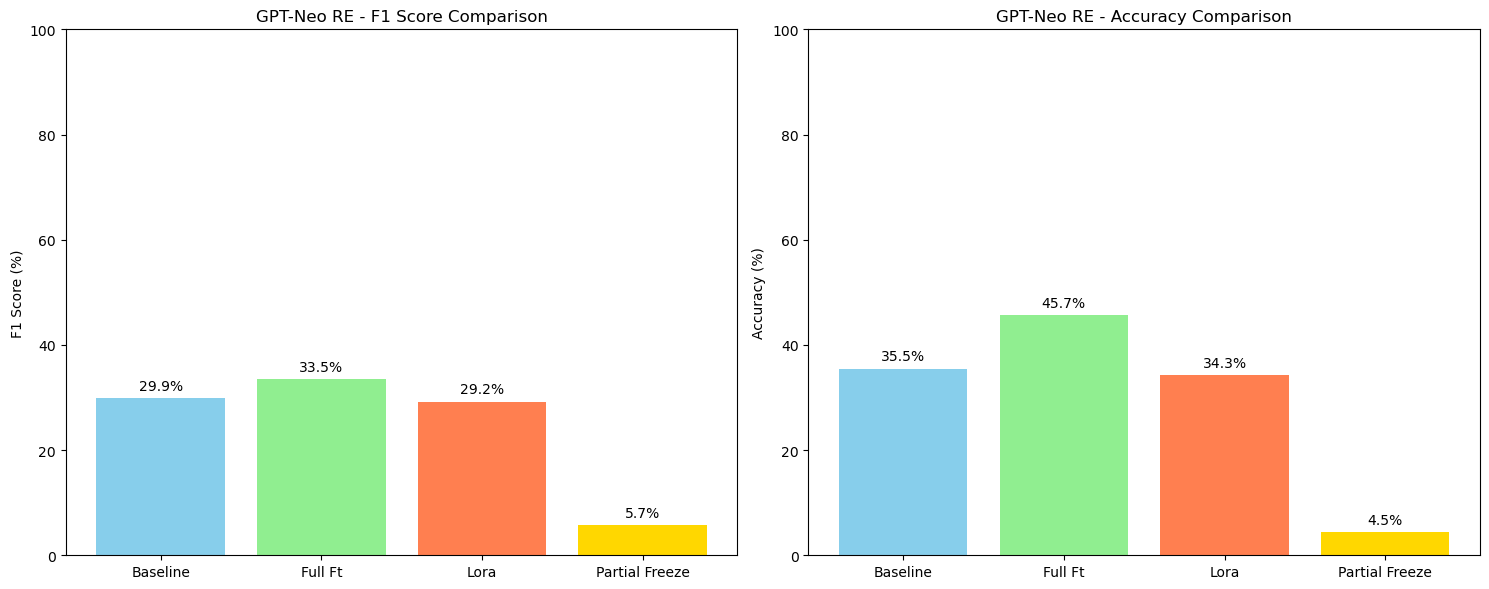


🏆 Best performing method: Full Ft
   F1 Score: 33.54%
   Accuracy: 45.71%


In [31]:
# Create comparison DataFrame
comparison_data = []
for method, metrics in results_summary.items():
    comparison_data.append({
        "Method": method.replace("_", " ").title(),
        "F1": metrics["eval_f1"] * 100,
        "Precision": metrics["eval_precision"] * 100,
        "Recall": metrics["eval_recall"] * 100,
        "Accuracy": metrics["eval_accuracy"] * 100,
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(2)

print("\n" + "="*50)
print("GPT-NEO RELATION EXTRACTION RESULTS")
print("="*50)
print(comparison_df.to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# F1 Score comparison
methods = comparison_df["Method"].tolist()
f1_scores = comparison_df["F1"].tolist()

ax1.bar(methods, f1_scores, color=['skyblue', 'lightgreen', 'coral', 'gold'])
ax1.set_ylabel('F1 Score (%)')
ax1.set_title('GPT-Neo RE - F1 Score Comparison')
ax1.set_ylim(0, 100)

for i, v in enumerate(f1_scores):
    ax1.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

# Accuracy comparison
accuracies = comparison_df["Accuracy"].tolist()
ax2.bar(methods, accuracies, color=['skyblue', 'lightgreen', 'coral', 'gold'])
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('GPT-Neo RE - Accuracy Comparison')
ax2.set_ylim(0, 100)

for i, v in enumerate(accuracies):
    ax2.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('outputs/gpt_neo_re_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Best performing method
best_method_idx = comparison_df["F1"].idxmax()
best_method = comparison_df.iloc[best_method_idx]
print(f"\n🏆 Best performing method: {best_method['Method']}")
print(f"   F1 Score: {best_method['F1']:.2f}%")
print(f"   Accuracy: {best_method['Accuracy']:.2f}%")

## 14. Hyperparameter Analysis

In [32]:
print("\n" + "="*50)
print("HYPERPARAMETER ANALYSIS")
print("="*50)

print("\n📊 Full Fine-Tuning Best Parameters:")
for param, value in study_ft.best_params.items():
    print(f"  {param}: {value}")

print(f"\n📊 LoRA Best Parameters:")
for param, value in study_lora.best_params.items():
    print(f"  {param}: {value}")

print(f"\n📊 Partial Freeze Best Parameters:")
for param, value in study_freeze.best_params.items():
    print(f"  {param}: {value}")

# Save results
comparison_df.to_csv("outputs/gpt_neo_re_results.csv", index=False)
print("\n✅ Results saved to outputs/gpt_neo_re_results.csv")

# Save best model
best_trainer = ft_trainer if best_method['Method'] == 'Full Ft' else (
    lora_trainer if best_method['Method'] == 'Lora' else freeze_trainer
)
best_trainer.save_model("outputs/gpt-neo-re-best-model")
tokenizer.save_pretrained("outputs/gpt-neo-re-best-model")
print("💾 Best model saved to outputs/gpt-neo-re-best-model/")


HYPERPARAMETER ANALYSIS

📊 Full Fine-Tuning Best Parameters:
  learning_rate: 2.903968752043959e-05
  batch_size: 16

📊 LoRA Best Parameters:
  learning_rate: 0.00046162295786666236
  r: 8
  alpha: 16
  dropout: 0.10221488340598575
  batch_size: 16

📊 Partial Freeze Best Parameters:
  learning_rate: 2.937090680094251e-05
  batch_size: 16
  freeze_pct: 0.29258562843873015

✅ Results saved to outputs/gpt_neo_re_results.csv
💾 Best model saved to outputs/gpt-neo-re-best-model/


## 15. Final Summary

In [33]:
# Create summary report
summary = {
    "task": "Relation Extraction",
    "model": "GPT-Neo 125M",
    "dataset": "DocIE",
    "best_method": best_method['Method'],
    "best_f1": float(best_method['F1']),
    "best_accuracy": float(best_method['Accuracy']),
    "training_examples": len(train_dataset),
    "dev_examples": len(dev_dataset),
    "num_classes": len(all_labels),
    "hyperparameter_trials": 8,
    "fine_tuning_methods": ["Full Fine-Tuning", "LoRA", "Partial Freezing"]
}

with open("outputs/gpt_neo_re_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\n📊 Summary report saved to outputs/gpt_neo_re_summary.json")


📊 Summary report saved to outputs/gpt_neo_re_summary.json
